# Normalization of samples in a dataset example

We will explore an Alzheimer dataset where the data was collected in four different sites.
We will see that the sites have a an effect where the data is in principal component space
and in UMAP space. We will then normalize the data and see how the effect on these plots.

Refers to the `acore.normalization` module.

In [1]:
%pip install acore

Note: you may need to restart the kernel to use updated packages.


In [2]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.impute
import sklearn.preprocessing
import umap

import acore.normalization
import acore.sklearn
from acore.sklearn import pca as acore_pca  # ! to remove


def plot_umap(X_scaled, y, meta_column, random_state=42) -> plt.Axes:
    """Fit and plot UMAP embedding with two components with colors defined by meta_column."""
    reducer = umap.UMAP(random_state=random_state, n_jobs=1)
    embedding = reducer.fit_transform(X_scaled)
    embedding = pd.DataFrame(
        embedding, index=X_scaled.index, columns=["UMAP 1", "UMAP 2"]
    ).join(y.astype("category"))
    ax = embedding.plot.scatter("UMAP 1", "UMAP 2", c=meta_column, cmap="Paired")
    return ax


def standard_normalize(X: pd.DataFrame) -> pd.DataFrame:
    """Standard normalize data and keep indices of DataFrame."""
    scaler = sklearn.preprocessing.StandardScaler()
    X_scaled = acore.sklearn.transform_DataFrame(X, fct=scaler.fit_transform)
    return X_scaled


def median_impute(X: pd.DataFrame) -> pd.DataFrame:
    median_imputer = sklearn.impute.SimpleImputer(strategy="median")
    X_imputed = acore.sklearn.transform_DataFrame(X, median_imputer.fit_transform)
    return X_imputed


def run_and_plot_pca(
    X_scaled,
    y,
    meta_column,
    n_components=4,
) -> tuple[pd.DataFrame, plt.Figure]:
    PCs, _ = acore_pca.run_pca(X_scaled, n_components=n_components)
    PCs.columns = [s.replace("principal component", "PC") for s in PCs.columns]
    PCs = PCs.join(y.astype("category"))
    up_to = min(PCs.shape[-1], n_components)
    fig, axes = plt.subplots(up_to - 1, 2, figsize=(6, 8), layout="constrained")
    for k, (pos, ax) in enumerate(
        zip(itertools.combinations(range(up_to), 2), axes.flatten())
    ):
        i, j = pos
        plot_heatmap = bool(k % 2)
        PCs.plot.scatter(
            i, j, c=meta_column, cmap="Paired", ax=ax, colorbar=plot_heatmap
        )
    _ = PCs.pop(
        meta_column,
    )
    return PCs, fig


## Set some parameters

In [3]:
fname_metadata: str = (
    "https://raw.githubusercontent.com/RasmussenLab/"
    "njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"  # clincial data
)
fname_omics: str = (
    "https://raw.githubusercontent.com/RasmussenLab/"
    "njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv"  # omics data
)
METACOL: str = "_collection site"  # target column in fname_metadata dataset (binary)
METACOL_LABEL: Optional[str] = "site"  # optional: rename target variable
n_features_max: int = 5
freq_cutoff: float = 0.5  # Omics cutoff for sample completeness
VAL_IDS: str = ""  #
VAL_IDS_query: str = ""
weights: bool = True
FOLDER = "alzheimer"
model_name = "all"

## Setup

### Load proteomics (protein groups) data

In [4]:
if METACOL_LABEL is None:
    METACOL_LABEL = METACOL
metadata = (
    pd.read_csv(fname_metadata, usecols=["Sample ID", METACOL], index_col=0)
    .convert_dtypes()
    .rename(columns={METACOL: METACOL_LABEL})
)
omics = pd.read_csv(fname_omics, index_col=0)

Data shapes

In [5]:
omics.shape, metadata.shape

((210, 1542), (210, 1))

See how common omics features are and remove feature below choosen frequency cutoff

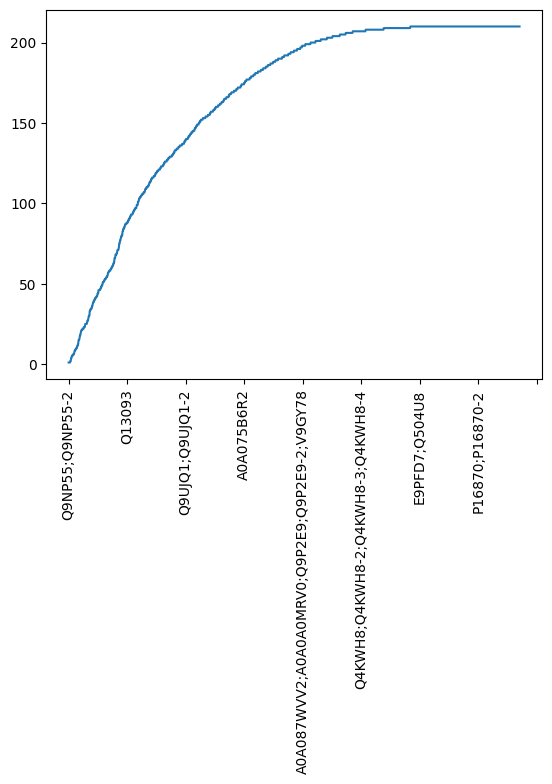

In [6]:
ax = omics.notna().sum().sort_values().plot(rot=90)

Removed 248 features with more than 50.0% missing values.
Remaining features: 1294 (of 1542)


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,NaN,...,16.012455,15.177822,NaN,15.050256,16.842226,19.863185,NaN,19.562819,12.837642,12.805408
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,NaN,19.067333,16.188013,...,15.527968,15.575561,NaN,14.832952,16.597404,20.299335,15.555612,19.385753,13.970065,12.442712
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,NaN,...,15.228744,14.727752,13.756689,15.118316,17.439526,19.597854,15.735246,20.447324,12.636637,12.504907
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,15.494870,14.590401,14.681625,15.140217,17.356093,19.428807,NaN,20.215965,12.627384,12.444874
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,14.756734,15.094203,14.047656,15.255915,17.074961,19.581978,15.328313,19.867112,13.144693,12.235109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,NaN,16.413052,19.102116,16.064249,...,15.235517,15.683895,14.235689,15.415073,17.550929,17.921852,16.340177,19.927666,12.929595,11.802901
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,15.422310,16.106347,NaN,15.345393,17.084479,18.708143,14.248772,19.432603,NaN,NaN
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,15.807981,16.097824,14.402791,15.715351,16.585579,18.724787,16.138287,19.599127,13.637167,11.174339


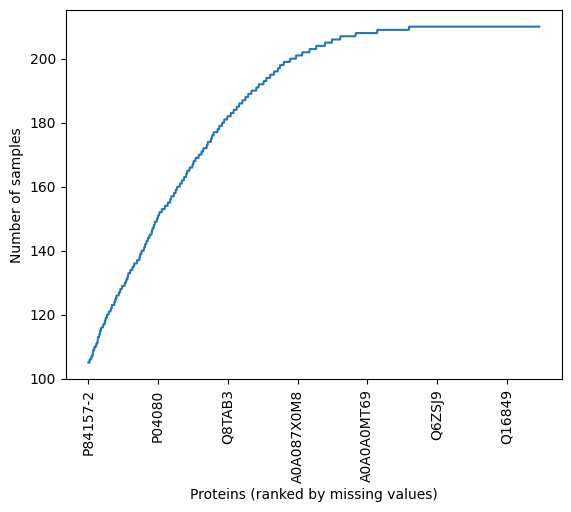

In [7]:
M_before = omics.shape[1]
omics = omics.dropna(thresh=int(len(omics) * freq_cutoff), axis=1)
M_after = omics.shape[1]
msg = (
    f"Removed {M_before-M_after} features with more "
    f"than {freq_cutoff*100}% missing values."
    f"\nRemaining features: {M_after} (of {M_before})"
)
print(msg)
# keep a map of all proteins in protein group, but only display first protein
# proteins are unique to protein groups
pg_map = {k: k.split(";")[0] for k in omics.columns}
omics = omics.rename(columns=pg_map)
# log2 transform raw intensity data:
omics = np.log2(omics + 1)
ax = (
    omics.notna()
    .sum()
    .sort_values()
    .plot(
        rot=90,
        ylabel="Number of samples",
        xlabel="Proteins (ranked by missing values)",
    )
)
omics

### Sample metadata

In [8]:
metadata

,site
Sample ID,
Sample_000,Sweden
Sample_001,Sweden
Sample_002,Sweden
Sample_003,Sweden
Sample_004,Sweden
...,...
Sample_205,Berlin
Sample_206,Berlin
Sample_207,Berlin


Tabulate selected metadata and check for missing values

In [9]:
metadata[METACOL_LABEL].value_counts(dropna=False)

site
Berlin       83
Sweden       60
Magdeburg    38
Kiel         16
<NA>         13
Name: count, dtype: Int64

In [10]:
target_counts = metadata[METACOL_LABEL].value_counts()

if target_counts.sum() < len(metadata):
    print(
        "Target has missing values."
        f" Can only use {target_counts.sum()} of {len(metadata)} samples."
    )
    mask = metadata[METACOL_LABEL].notna()
    metadata, omics = metadata.loc[mask], omics.loc[mask]

if METACOL_LABEL is None:
    METACOL_LABEL = METACOL_LABEL
y = metadata[METACOL_LABEL].astype("category")

Target has missing values. Can only use 197 of 210 samples.


For simplicity we normalize here all samples together, but normally you would need to
apply the normalization from you training data to the test data. So see these examples
here as a way to do it for your training data.

### Fill missing values for preliminary plots

Impute using median to impute (before scaling, which can be changed).

In [11]:
omics_imputed = median_impute(omics)
assert omics_imputed.isna().sum().sum() == 0
omics_imputed.shape

(197, 1294)

## Dimensionality reduction - unnormalized data
on median imputed and standard normalized omics data.

### Principal Components
Plot first 4 PCs with categorical metadata as label annotating each sample.

(197, 1294)

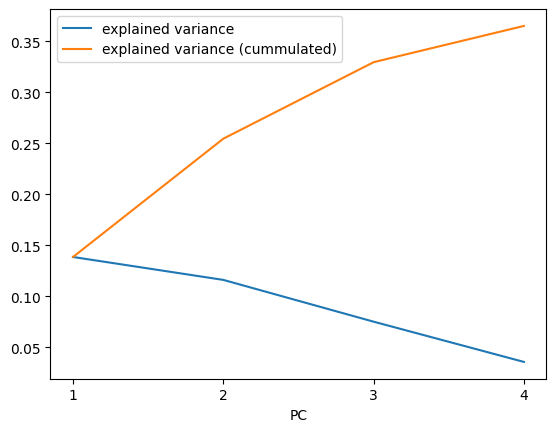

In [12]:
omics_imp_scaled = standard_normalize(omics_imputed)

PCs, pca = acore_pca.run_pca(omics_imp_scaled, n_components=4)
ax = acore_pca.plot_explained_variance(pca)
ax.locator_params(axis="x", integer=True)
omics_imp_scaled.shape

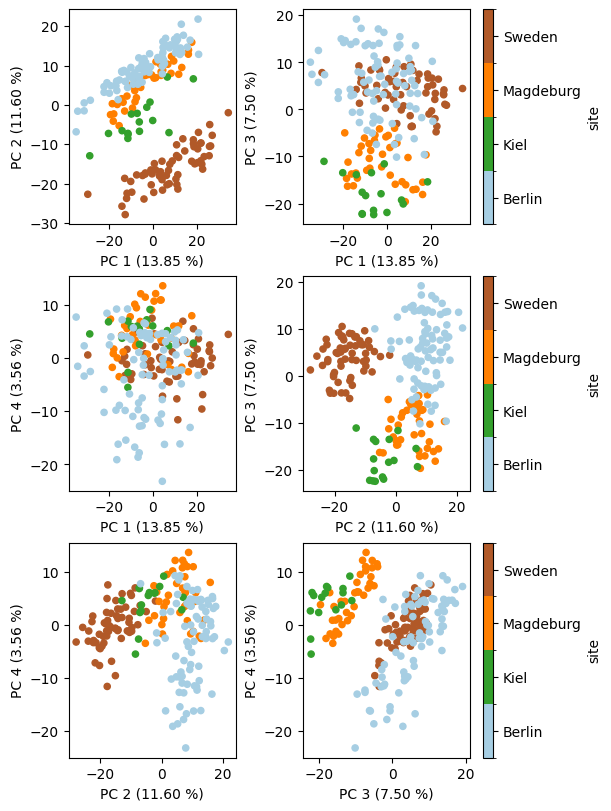

In [13]:
pcs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL)

### UMAP
of median imputed and normalized omics data:

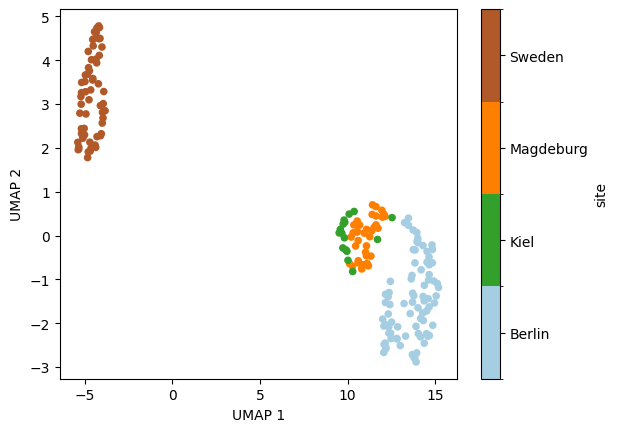

In [14]:
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

## Normalization of samples in a dataset
We will use the `acore.normalization` module to normalize the data.

We will do it for each of the data on the omics dataset which is log transformed,
but not yet imputed and normalized. Then we will reapply standard
normalization before replotting the PCA and UMAP plots. The execption is combat as it
need complete data.

In [15]:
omics

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,16.690813,...,16.012455,15.177822,14.235689,15.050256,16.842226,19.863185,15.322114,19.562819,12.837642,12.805408
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,16.239304,19.067333,16.188013,...,15.527968,15.575561,14.235689,14.832952,16.597404,20.299335,15.555612,19.385753,13.970065,12.442712
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,16.690813,...,15.228744,14.727752,13.756689,15.118316,17.439526,19.597854,15.735246,20.447324,12.636637,12.504907
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,15.494870,14.590401,14.681625,15.140217,17.356093,19.428807,15.322114,20.215965,12.627384,12.444874
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,14.756734,15.094203,14.047656,15.255915,17.074961,19.581978,15.328313,19.867112,13.144693,12.235109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,17.456518,16.413052,19.102116,16.064249,...,15.235517,15.683895,14.235689,15.415073,17.550929,17.921852,16.340177,19.927666,12.929595,11.802901
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,15.422310,16.106347,14.235689,15.345393,17.084479,18.708143,14.248772,19.432603,12.528015,11.457565
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,15.807981,16.097824,14.402791,15.715351,16.585579,18.724787,16.138287,19.599127,13.637167,11.174339


### Combat normalization
Correct for batch effects in the data using a robust regression approach normalizing
mean and scale effetcs out for each feature by batch. Assumes normally distributed data.

> ⚠️ Combat needs imputed data

In [16]:
%%time
X = median_impute(omics)
X = acore.normalization.combat_batch_correction(
    X.join(y),
    batch_col="site",
)
X

CPU times: user 66.6 ms, sys: 26 ms, total: 92.6 ms
Wall time: 13.7 ms


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.808193,17.268879,15.371916,16.423722,19.470138,16.372425,17.116693,16.507555,20.190648,16.847815,...,16.064461,15.442751,14.337256,14.970679,16.812597,19.547495,15.136645,19.343452,12.628919,12.884747
Sample_001,15.831319,17.285843,15.309903,16.337478,19.121593,18.573190,16.717585,15.892798,19.129199,16.368173,...,15.555579,15.798678,14.337256,14.718870,16.540267,19.981732,15.456526,19.190679,13.942374,12.420608
Sample_002,16.004689,15.452821,15.810796,16.363886,18.333777,16.446129,15.380406,16.527306,18.593252,16.847815,...,15.241287,15.039994,13.504135,15.049546,17.477013,19.283329,15.702616,20.106605,12.395782,12.500198
Sample_003,16.000225,17.408903,15.650267,16.879548,18.764175,17.556341,18.291195,14.202739,19.040714,13.745065,...,15.520814,14.917082,15.112870,15.074924,17.384205,19.115024,15.136645,19.906988,12.385049,12.423374
Sample_004,15.503109,16.082566,15.137043,16.605099,19.702268,18.459555,16.660787,14.168800,19.794263,14.753042,...,14.745510,15.367923,14.010212,15.208994,17.071484,19.267523,15.145138,19.605997,12.985056,12.154940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.753927,16.711344,15.082347,16.545683,18.465045,17.089304,17.840612,16.525182,19.057108,16.069036,...,15.240435,15.503087,14.159664,15.340759,17.749774,18.258071,16.014764,20.019834,12.871402,11.940594
Sample_206,15.861905,17.471823,15.667142,15.997023,18.850696,18.228839,16.802700,16.979240,18.543175,15.293901,...,15.436962,15.948357,14.159664,15.277990,17.298620,19.016609,14.250078,19.514879,12.453582,11.597989
Sample_207,15.807301,16.700929,15.556307,16.964272,19.263939,18.022524,16.604719,16.512661,18.826498,17.582558,...,15.842730,15.939374,14.307836,15.611257,16.816079,19.032665,15.844413,19.684729,13.607589,11.317003


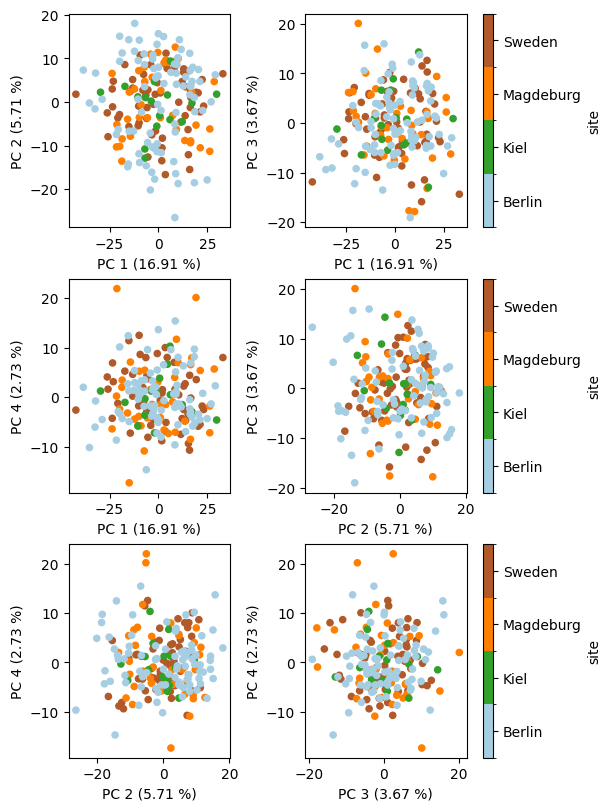

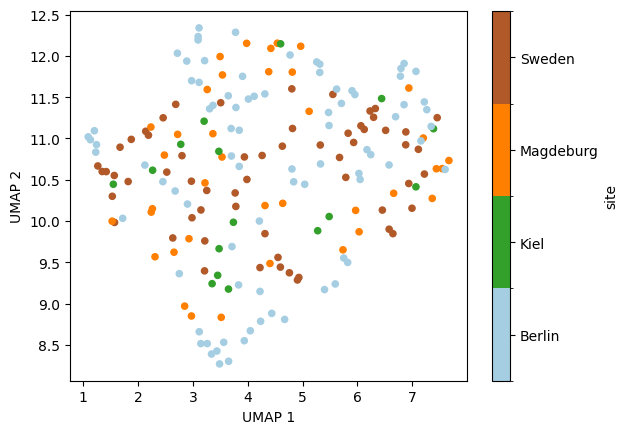

In [17]:
omics_imp_scaled = standard_normalize(omics_imp_scaled)
PCs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL, n_components=4)
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

See change by substracting combat normalized data from original data.

In [18]:
omics - X

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,0.104203,-0.416931,0.198589,0.057374,0.776321,0.392052,0.466885,0.480234,-0.136483,-0.157002,...,-0.052006,-0.264929,-0.101568,0.079577,0.029628,0.315689,0.185469,0.219367,0.208722,-0.079339
Sample_001,0.104511,-0.412139,0.209051,0.049482,0.819508,0.213052,0.426307,0.346507,-0.061866,-0.180160,...,-0.027610,-0.223117,-0.101568,0.114082,0.057137,0.317603,0.099086,0.195074,0.027690,0.022105
Sample_002,0.106823,-0.929906,0.124546,0.051899,0.917122,0.386057,0.290351,0.484530,-0.024191,-0.157002,...,-0.012543,-0.312242,0.252554,0.068770,-0.037487,0.314525,0.032631,0.340719,0.240855,0.004709
Sample_003,0.106764,-0.377379,0.151628,0.099085,0.863794,0.295757,0.586301,-0.021129,-0.055646,-0.306808,...,-0.025944,-0.326681,-0.431246,0.065293,-0.028112,0.313783,0.185469,0.308977,0.242335,0.021500
Sample_004,0.100134,-0.752024,0.238214,0.073971,0.747559,0.222294,0.420532,-0.028511,-0.108619,-0.258141,...,0.011224,-0.273719,0.037444,0.046922,0.003477,0.314455,0.183175,0.261115,0.159636,0.080170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,-0.071646,0.175018,-0.172239,-0.063347,-0.760184,-0.049841,-0.384094,-0.112129,0.045008,-0.004788,...,-0.004918,0.180808,0.076025,0.074314,-0.198845,-0.336219,0.325413,-0.092168,0.058193,-0.137693
Sample_206,-0.063840,0.082188,-0.067457,-0.059180,-0.696195,-0.077047,-0.300010,-0.119198,-0.005213,-0.006161,...,-0.014652,0.157989,0.076025,0.067404,-0.214141,-0.308466,-0.001306,-0.082275,0.074433,-0.140424
Sample_207,-0.067788,0.176289,-0.087316,-0.066526,-0.627629,-0.072121,-0.283971,-0.111934,0.022473,-0.002107,...,-0.034749,0.158450,0.094955,0.104093,-0.230500,-0.307878,0.293874,-0.085603,0.029578,-0.142664


## Median normalization
Substracts a constant from all features of a sample. All samples will have the same
global median.

In [19]:
%%time
X = acore.normalization.normalize_data(omics, "median")
X

CPU times: user 10.3 ms, sys: 461 μs, total: 10.8 ms
Wall time: 10.9 ms


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.728950,16.668502,15.387059,16.297651,20.063014,16.581031,17.400133,16.804344,19.870719,16.507368,...,15.829009,14.994377,14.052243,14.866811,16.658780,19.679739,15.138669,19.379374,12.654196,12.621963
Sample_001,15.918827,16.856701,15.501951,16.369958,19.924098,18.769238,17.126889,16.222301,19.050330,16.171011,...,15.510965,15.558559,14.218686,14.815949,16.580401,20.282333,15.538609,19.368750,13.953062,12.425709
Sample_002,16.036424,14.447826,15.860252,16.340696,19.175810,16.757097,15.595669,16.936747,18.493972,16.615724,...,15.153655,14.652663,13.681600,15.043227,17.364437,19.522765,15.660157,20.372235,12.561548,12.429818
Sample_003,15.984955,16.909491,15.679862,16.856599,19.505935,17.730064,18.755462,14.059577,18.863034,13.316223,...,15.372836,14.468367,14.559591,15.018183,17.234059,19.306773,15.200080,20.093931,12.505350,12.322840
Sample_004,15.559734,15.287034,15.331749,16.635562,20.406319,18.638341,17.037810,14.096781,19.642136,14.451392,...,14.713225,15.050695,14.004148,15.212407,17.031453,19.538470,15.284805,19.823604,13.101184,12.191601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.601545,16.805626,14.829371,16.401600,17.624125,16.958727,17.375782,16.332317,19.021380,15.983513,...,15.154781,15.603159,14.154953,15.334337,17.470193,17.841116,16.259442,19.846930,12.848859,11.722165
Sample_206,15.736017,17.491963,15.537638,15.875795,18.092453,18.089745,16.440642,16.797994,18.475915,15.225693,...,15.360262,16.044299,14.173641,15.283346,17.022431,18.646096,14.186724,19.370556,12.465967,11.395518
Sample_207,15.614952,16.752658,15.344430,16.773185,18.511749,17.825842,16.196186,16.276166,18.724409,17.455889,...,15.683420,15.973263,14.278230,15.590790,16.461018,18.600226,16.013726,19.474566,13.512606,11.049778


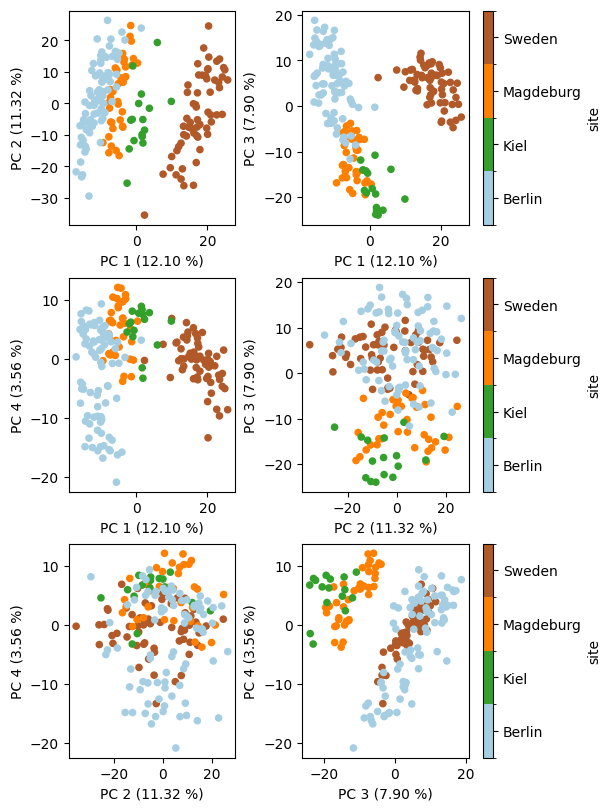

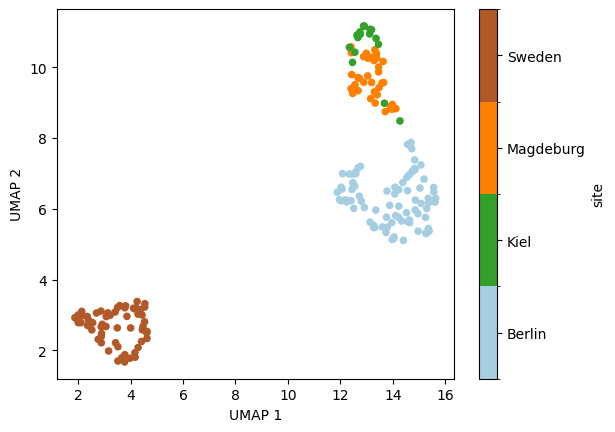

In [20]:
omics_imp_scaled = median_impute(X)
omics_imp_scaled = standard_normalize(omics_imp_scaled)
PCs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL, n_components=4)
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

See change by substracting median normalized data from original data.

In [21]:
omics - X

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,...,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445,0.183445
Sample_001,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,...,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003,0.017003
Sample_002,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,...,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089,0.075089
Sample_003,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,...,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034,0.122034
Sample_004,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,...,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508,0.043508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,...,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736,0.080736
Sample_206,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,...,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048,0.062048
Sample_207,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,...,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561,0.124561


## Z-score normalization
Normalize a sample by it's mean and standard deviation.

In [22]:
%%time
X = acore.normalization.normalize_data(omics, "zscore")
X

CPU times: user 2.64 ms, sys: 948 μs, total: 3.59 ms
Wall time: 4.79 ms


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,-0.519890,-0.140051,-0.658108,-0.289977,1.232270,-0.175413,0.155730,-0.085133,1.154530,-0.205194,...,-0.479438,-0.816860,-1.197743,-0.868432,-0.143981,1.077322,-0.758527,0.955891,-1.762940,-1.775971
Sample_001,-0.476776,-0.095996,-0.646028,-0.293615,1.149374,0.680498,0.013700,-0.353564,0.794622,-0.374389,...,-0.642368,-0.623046,-1.167037,-0.924547,-0.208175,1.294818,-0.631145,0.923901,-1.274881,-1.894990
Sample_002,-0.408206,-1.071934,-0.481812,-0.281078,0.903454,-0.107103,-0.592357,-0.032044,0.618577,-0.166170,...,-0.777033,-0.986352,-1.392069,-0.823171,0.146648,1.048414,-0.565413,1.403329,-1.860036,-1.915073
Sample_003,-0.426881,-0.053029,-0.550250,-0.074416,0.996889,0.278785,0.693422,-1.205441,0.736921,-1.506029,...,-0.674402,-1.040140,-1.003251,-0.817812,0.078217,0.916354,-0.744258,1.234656,-1.833920,-1.907721
Sample_004,-0.622091,-0.732847,-0.714686,-0.185151,1.346316,0.628264,-0.021781,-1.216260,1.035948,-1.072237,...,-0.965895,-0.828834,-1.253882,-0.763156,-0.024363,0.993845,-0.733752,1.109650,-1.620614,-1.990035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,-0.575762,-0.068662,-0.900963,-0.238818,0.276049,-0.004184,0.171459,-0.267997,0.864504,-0.414896,...,-0.763917,-0.575082,-1.184995,-0.688296,0.211221,0.367435,-0.298688,1.212185,-1.735057,-2.209565
Sample_206,-0.513987,0.204943,-0.595209,-0.456758,0.450798,0.449690,-0.225495,-0.079186,0.607798,-0.722927,...,-0.667831,-0.387768,-1.153664,-0.699322,0.012704,0.677474,-1.148308,0.974087,-1.852830,-2.291100
Sample_207,-0.568378,-0.100390,-0.679655,-0.091946,0.623201,0.341058,-0.329291,-0.296392,0.710678,0.188880,...,-0.540214,-0.420989,-1.118230,-0.578317,-0.220354,0.659596,-0.404344,1.019250,-1.433164,-2.446233


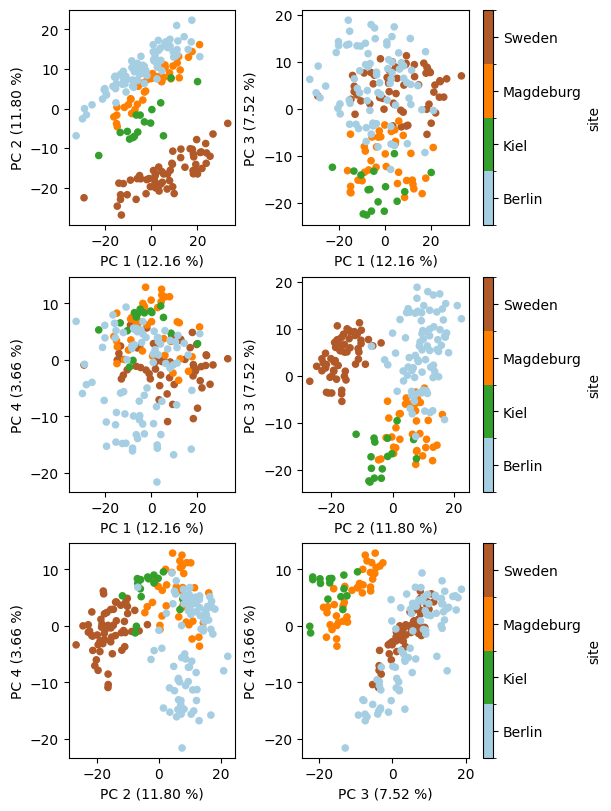

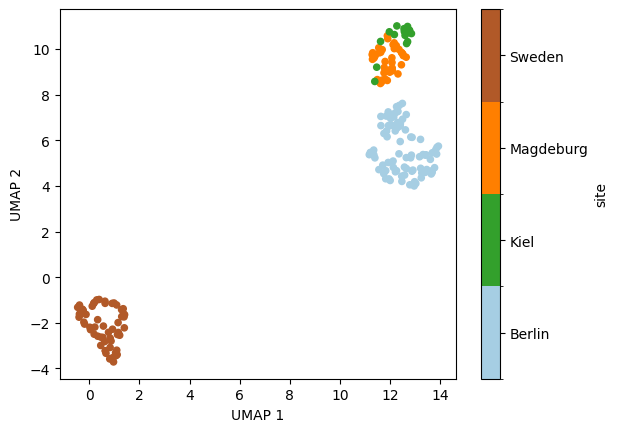

In [23]:
omics_imp_scaled = median_impute(X)
omics_imp_scaled = standard_normalize(omics_imp_scaled)
PCs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL, n_components=4)
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

See change by substracting z-score normalized data from original data.

In [24]:
omics_imp_scaled - X

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,0.901136,-0.694305,0.508634,0.440835,-0.533329,-1.788341,-0.094844,0.927382,-0.828994,0.022151,...,1.563749,-0.126249,0.828014,0.435444,-0.113724,-0.353057,0.494886,-1.123247,2.004097,3.516086
Sample_001,1.176682,-0.613569,0.575797,0.419751,-0.610219,-0.384408,-0.209061,0.308275,-1.542558,-0.344481,...,0.921150,0.554027,0.910529,0.086896,-0.285285,0.276539,0.920627,-1.232458,3.156181,3.174926
Sample_002,1.614921,-2.402124,1.488837,0.492407,-0.838320,-1.676293,-0.696440,1.049827,-1.891590,0.106713,...,0.390029,-0.721152,0.305803,0.716577,0.662994,-0.436735,1.140321,0.404293,1.774899,3.117357
Sample_003,1.495569,-0.534824,1.108319,1.690078,-0.751655,-1.043330,0.337557,-1.656485,-1.656958,-2.796657,...,0.794811,-0.909943,1.350669,0.749865,0.480107,-0.819015,0.542573,-0.171554,1.836547,3.138433
Sample_004,0.247951,-1.780694,0.194063,1.048334,-0.427548,-0.470087,-0.237595,-1.681437,-1.064098,-1.856663,...,-0.354843,-0.168276,0.677152,1.089354,0.205960,-0.594700,0.577689,-0.598318,2.340063,2.902482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,0.544048,-0.563474,-0.841632,0.737319,-1.420262,-1.507477,-0.082195,0.505627,-1.404008,-0.432257,...,0.441762,0.722376,0.862271,1.554332,0.835566,-2.407992,2.031783,-0.248266,2.069916,2.273210
Sample_206,0.938860,-0.062052,0.858352,-0.525713,-1.258176,-0.762997,-0.401417,0.941098,-1.912961,-1.099736,...,0.820726,1.379832,0.946466,1.485846,0.305023,-1.510510,-0.807862,-1.061126,1.791909,2.039496
Sample_207,0.591241,-0.621620,0.388832,1.588488,-1.098265,-0.941185,-0.484887,0.440138,-1.708988,0.876078,...,1.324048,1.263231,1.041689,2.237455,-0.317833,-1.562263,1.678653,-0.906942,2.782547,1.594814


## Median Polish Normalization
- normalize iteratively features and samples to have zero median.

In [25]:
%%time
X = acore.normalization.normalize_data(omics, "median_polish")
X

CPU times: user 6.19 s, sys: 157 ms, total: 6.34 s
Wall time: 6.37 s


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.805317,17.724385,15.623814,16.401556,19.466339,18.592329,17.626579,16.409678,19.746351,16.860875,...,15.426806,15.699586,14.405750,15.170506,16.928404,19.451169,15.492175,19.677424,12.698389,11.627939
Sample_001,15.663739,17.582807,15.482236,16.259978,19.324761,18.450751,17.485001,16.268101,19.604774,16.719297,...,15.285229,15.558008,14.264172,15.028928,16.786827,19.309591,15.350598,19.535846,12.556811,11.486361
Sample_002,15.694247,17.613315,15.512745,16.290486,19.355270,18.481259,17.515509,16.298609,19.635282,16.749805,...,15.315737,15.588516,14.294681,15.059436,16.817335,19.340099,15.381106,19.566354,12.587319,11.516870
Sample_003,15.746876,17.665944,15.565373,16.343115,19.407898,18.533888,17.568138,16.351238,19.687911,16.802434,...,15.368366,15.641145,14.347309,15.112065,16.869964,19.392728,15.433735,19.618983,12.639948,11.569498
Sample_004,15.657679,17.576747,15.476176,16.253918,19.318701,18.444691,17.478941,16.262041,19.598714,16.713237,...,15.279169,15.551948,14.258112,15.022868,16.780767,19.303531,15.344538,19.529786,12.550751,11.480301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.707312,17.626380,15.525809,16.303551,19.368334,18.494324,17.528574,16.311673,19.648346,16.762870,...,15.328802,15.601581,14.307745,15.072501,16.830399,19.353164,15.394170,19.579419,12.600384,11.529934
Sample_206,15.646303,17.565371,15.464800,16.242542,19.307325,18.433315,17.467565,16.250664,19.587337,16.701861,...,15.267793,15.540572,14.246736,15.011492,16.769390,19.292155,15.333161,19.518410,12.539375,11.468925
Sample_207,15.735925,17.654992,15.554422,16.332164,19.396947,18.522936,17.557187,16.340286,19.676959,16.791483,...,15.357414,15.630193,14.336358,15.101114,16.859012,19.381777,15.422783,19.608032,12.628997,11.558547


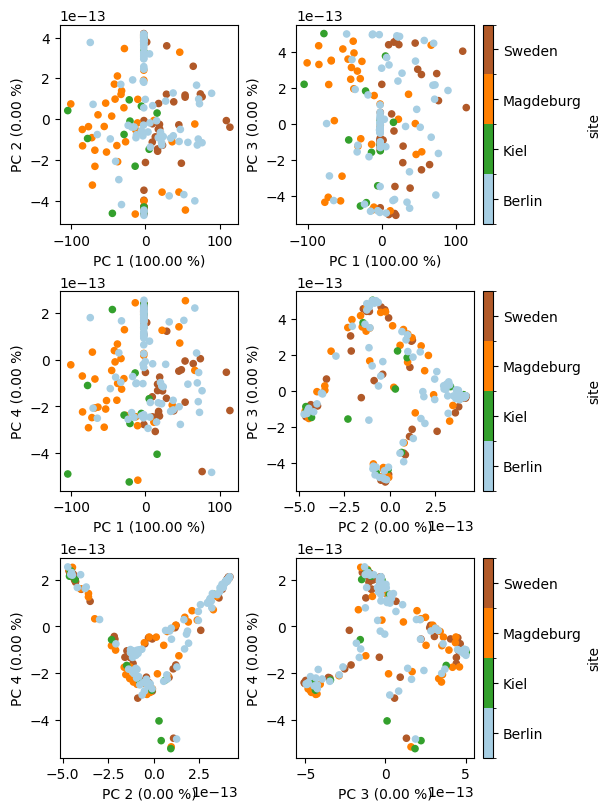

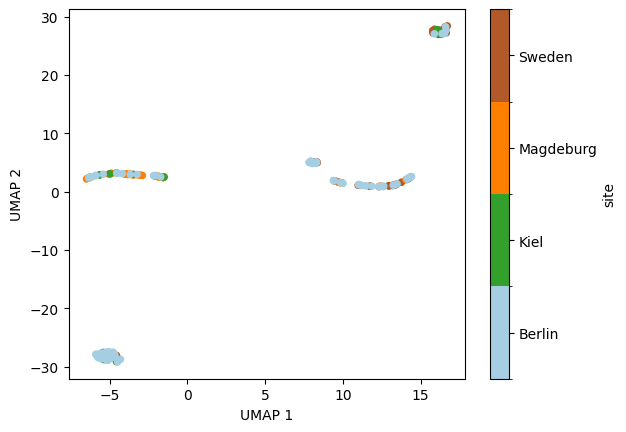

In [26]:
omics_imp_scaled = median_impute(X)
omics_imp_scaled = standard_normalize(omics_imp_scaled)
PCs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL, n_components=4)
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

See change by substracting median polish normalized data from original data.

In [27]:
omics_imp_scaled - X

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,-12.640997,-14.560065,-12.459494,-13.237236,-16.302019,-15.428009,-14.462259,-13.245358,-16.582031,-13.696555,...,-12.262487,-12.535266,-11.241430,-12.006186,-13.764084,-16.286849,-12.327855,-16.513104,-9.534069,-8.463619
Sample_001,-15.181510,-17.100577,-15.000007,-15.777748,-18.842532,-17.968521,-17.002772,-15.785871,-19.122544,-16.237067,...,-14.802999,-15.075778,-13.781943,-14.546699,-16.304597,-18.827362,-14.868368,-19.053617,-12.074582,-11.004132
Sample_002,-14.634062,-16.553130,-14.452560,-15.230301,-18.295085,-17.421074,-16.455325,-15.238424,-18.575097,-15.689620,...,-14.255552,-14.528331,-13.234496,-13.999251,-15.757150,-18.279915,-14.320921,-18.506169,-11.527134,-10.456685
Sample_003,-13.689674,-15.608742,-13.508172,-14.285913,-17.350697,-16.476686,-15.510937,-14.294036,-17.630709,-14.745232,...,-13.311164,-13.583943,-12.290108,-13.054864,-14.812762,-17.335527,-13.376533,-17.561781,-10.582746,-9.512297
Sample_004,-15.290252,-17.209320,-15.108749,-15.886491,-18.951274,-18.077264,-17.111514,-15.894613,-19.231286,-16.345810,...,-14.911742,-15.184521,-13.890685,-14.655441,-16.413339,-18.936104,-14.977110,-19.162359,-12.183324,-11.112874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,-14.399627,-16.318695,-14.218124,-14.995866,-18.060649,-17.186639,-16.220889,-15.003989,-18.340662,-15.455185,...,-14.021117,-14.293896,-13.000060,-13.764816,-15.522715,-18.045479,-14.086486,-18.271734,-11.292699,-10.222249
Sample_206,-15.494390,-17.413458,-15.312888,-16.090629,-19.155413,-18.281402,-17.315653,-16.098752,-19.435425,-16.549948,...,-15.115880,-15.388659,-14.094824,-14.859579,-16.617478,-19.140243,-15.181249,-19.366497,-12.387462,-11.317013
Sample_207,-13.886189,-15.805257,-13.704687,-14.482428,-17.547212,-16.673201,-15.707452,-14.490551,-17.827224,-14.941747,...,-13.507679,-13.780458,-12.486623,-13.251378,-15.009277,-17.532042,-13.573048,-17.758296,-10.779261,-9.708812


## Quantile normalization
quantile normalize each feature column.

In [28]:
%%time
X = acore.normalization.normalize_data(omics, "quantile")
X

CPU times: user 44.6 ms, sys: 4.29 ms, total: 48.9 ms
Wall time: 51.4 ms


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.763429,16.688628,15.405385,16.304943,20.175094,16.576246,17.405596,16.827318,19.921305,16.491342,...,15.883349,15.006329,13.992393,14.857334,16.672303,19.643828,15.167299,19.351085,12.204185,12.128057
Sample_001,15.846800,16.831633,15.413713,16.382970,19.899124,18.768519,17.107767,16.203987,19.066258,16.121097,...,15.421313,15.493547,14.032781,14.746587,16.571763,20.244512,15.449664,19.359984,13.767505,11.718914
Sample_002,16.046788,14.349152,15.890620,16.366429,19.136999,16.741910,15.616311,16.868606,18.455262,16.637028,...,15.167299,14.593322,13.576509,15.040016,17.349260,19.535336,15.693120,20.500314,12.038886,11.718914
Sample_003,15.974451,16.859260,15.708049,16.813479,19.435112,17.645869,18.694763,13.973151,18.863228,13.303728,...,15.344640,14.465595,14.550832,14.973227,17.168265,19.255714,15.180934,20.175094,12.330557,12.038886
Sample_004,15.538426,15.234125,15.291044,16.623601,20.467887,18.515489,17.021436,13.875273,19.494767,14.342412,...,14.569527,14.996445,13.779039,15.153141,17.012602,19.416818,15.229788,19.762292,12.330557,10.245388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.616311,16.836540,14.835375,16.382970,17.676283,16.997664,17.456927,16.308954,19.210558,15.992283,...,15.176668,15.619899,14.100951,15.360460,17.562120,17.907074,16.240416,20.029127,12.330557,10.849600
Sample_206,15.689291,17.596849,15.489598,15.842727,18.183524,18.168680,16.444259,16.859260,18.570538,15.189691,...,15.291044,16.010787,14.061678,15.246792,17.122731,18.786934,14.081117,19.544705,12.497929,11.718914
Sample_207,15.604308,16.733067,15.242754,16.764537,18.570538,17.893863,16.244824,16.320501,18.853281,17.499757,...,15.708049,16.028301,14.110655,15.573550,16.491342,18.677687,16.062033,19.632957,13.339360,11.409846


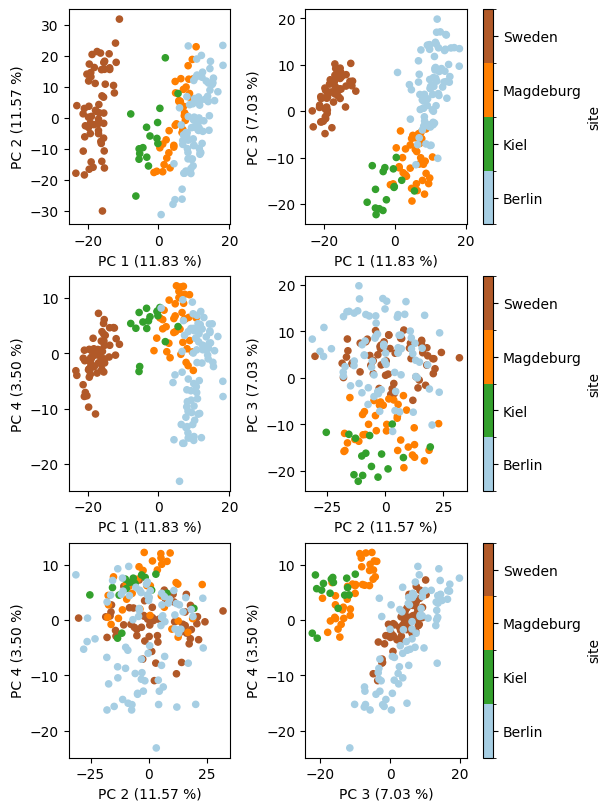

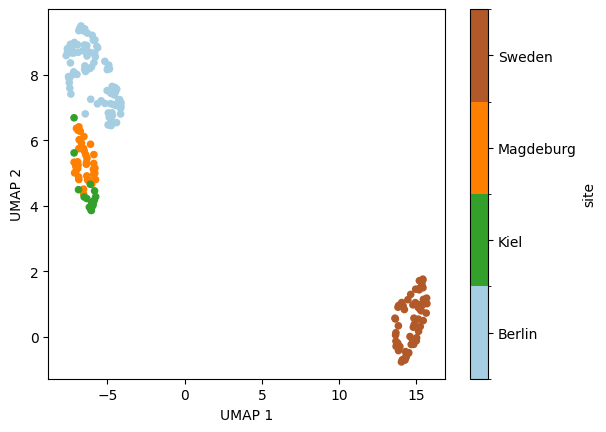

In [29]:
omics_imp_scaled = median_impute(X)
omics_imp_scaled = standard_normalize(omics_imp_scaled)
PCs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL, n_components=4)
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

In [30]:
omics - X

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,0.148966,0.163320,0.165119,0.176153,0.071365,0.188231,0.177982,0.160471,0.132860,0.199471,...,0.129106,0.171493,0.243296,0.192923,0.169923,0.219357,0.154815,0.211734,0.633456,0.677351
Sample_001,0.089029,0.042071,0.105241,0.003990,0.041977,0.017722,0.036125,0.035317,0.001075,0.066916,...,0.106655,0.082015,0.202907,0.086365,0.025641,0.054823,0.105948,0.025768,0.202560,0.723799
Sample_002,0.064724,0.173763,0.044721,0.049356,0.113900,0.090276,0.054447,0.143230,0.113799,0.053785,...,0.061445,0.134430,0.180180,0.078300,0.090266,0.062518,0.042126,-0.052990,0.597751,0.785993
Sample_003,0.132538,0.172264,0.093847,0.165154,0.192856,0.206229,0.182733,0.208460,0.121840,0.134529,...,0.150230,0.124806,0.130792,0.166990,0.187828,0.173092,0.141180,0.040871,0.296827,0.405988
Sample_004,0.064817,0.096417,0.084213,0.055469,-0.018060,0.166360,0.059882,0.265016,0.190878,0.152488,...,0.187206,0.097758,0.268617,0.102774,0.062359,0.165160,0.098525,0.104820,0.814136,1.989721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,0.065970,0.049823,0.074732,0.099366,0.028578,0.041799,-0.000409,0.104098,-0.108442,0.071965,...,0.058849,0.063996,0.134738,0.054613,-0.011191,0.014778,0.099761,-0.101461,0.599038,0.953300
Sample_206,0.108774,-0.042839,0.110087,0.095115,-0.029024,-0.016887,0.058431,0.000781,-0.032576,0.098050,...,0.131266,0.095560,0.174011,0.098601,-0.038252,-0.078791,0.167654,-0.112101,0.030086,-0.261348
Sample_207,0.135204,0.144151,0.226237,0.133209,0.065772,0.056540,0.075924,0.080225,-0.004311,0.080693,...,0.099932,0.069523,0.292136,0.141801,0.094237,0.047100,0.076254,-0.033830,0.297807,-0.235507


## Linear normalization

In [31]:
%%time
X = acore.normalization.normalize_data(omics, "linear")
X

CPU times: user 1.36 ms, sys: 637 μs, total: 1.99 ms
Wall time: 1.89 ms


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,0.005183,0.004911,0.005123,0.005152,0.005346,0.004609,0.005145,0.005334,0.005178,0.005085,...,0.005326,0.004974,0.005066,0.005097,0.005078,0.005232,0.005098,0.005088,0.005253,0.005689
Sample_001,0.005191,0.004917,0.005106,0.005123,0.005265,0.005165,0.005016,0.005099,0.004923,0.004932,...,0.005165,0.005104,0.005066,0.005023,0.005004,0.005347,0.005176,0.005042,0.005716,0.005528
Sample_002,0.005248,0.004232,0.005243,0.005132,0.005083,0.004628,0.004585,0.005342,0.004795,0.005085,...,0.005065,0.004826,0.004895,0.005120,0.005258,0.005163,0.005235,0.005318,0.005171,0.005556
Sample_003,0.005247,0.004963,0.005199,0.005308,0.005182,0.004908,0.005523,0.004453,0.004902,0.004094,...,0.005154,0.004781,0.005225,0.005128,0.005233,0.005118,0.005098,0.005258,0.005167,0.005529
Sample_004,0.005082,0.004467,0.005059,0.005214,0.005399,0.005136,0.004998,0.004440,0.005083,0.004416,...,0.004908,0.004946,0.004999,0.005167,0.005148,0.005158,0.005100,0.005167,0.005378,0.005436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,0.005108,0.004921,0.004906,0.005153,0.004675,0.004685,0.005107,0.005154,0.004932,0.004894,...,0.005067,0.005140,0.005066,0.005221,0.005291,0.004721,0.005437,0.005183,0.005290,0.005244
Sample_206,0.005146,0.005115,0.005133,0.004982,0.004793,0.004990,0.004828,0.005294,0.004787,0.004658,...,0.005130,0.005278,0.005066,0.005197,0.005151,0.004928,0.004741,0.005054,0.005126,0.005090
Sample_207,0.005127,0.004918,0.005090,0.005283,0.004921,0.004935,0.004775,0.005150,0.004867,0.005356,...,0.005258,0.005275,0.005125,0.005322,0.005000,0.004933,0.005369,0.005097,0.005580,0.004965


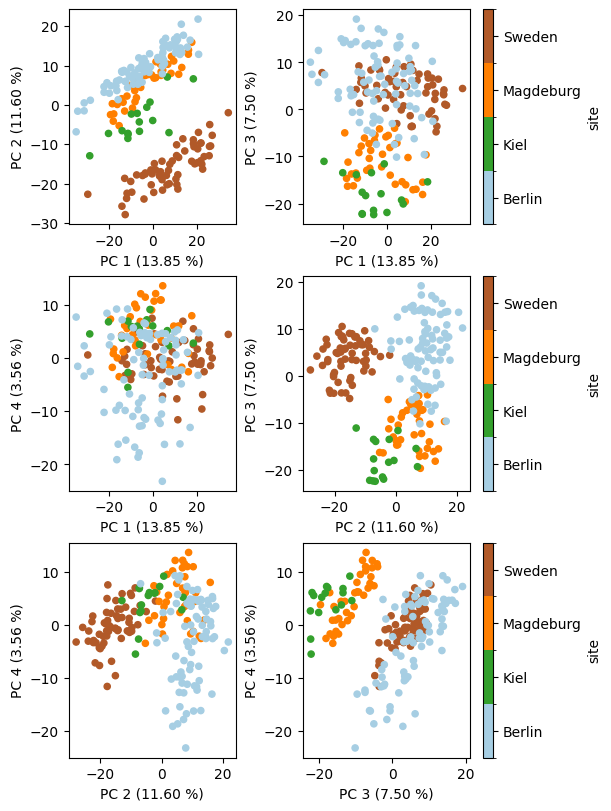

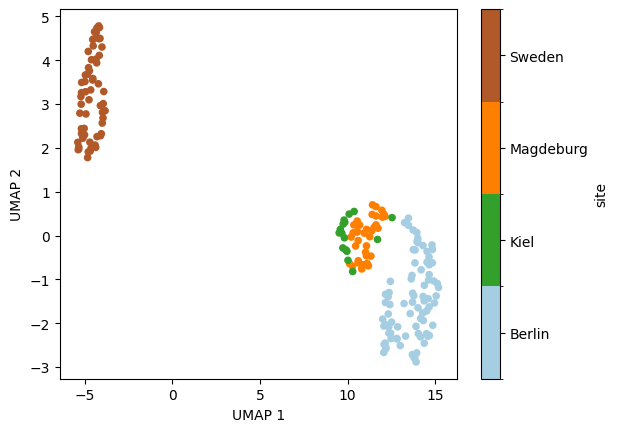

In [32]:
omics_imp_scaled = median_impute(X)
omics_imp_scaled = standard_normalize(omics_imp_scaled)
PCs, fig = run_and_plot_pca(omics_imp_scaled, y, METACOL_LABEL, n_components=4)
ax = plot_umap(omics_imp_scaled, y, METACOL_LABEL)

In [33]:
omics - X

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.907213,16.847037,15.565382,16.475944,20.241113,16.759868,17.578433,16.982455,20.048986,16.685728,...,16.007129,15.172848,14.230623,15.045159,16.837148,19.857952,15.317016,19.557731,12.832389,12.799719
Sample_001,15.930639,16.868787,15.513848,16.381838,19.935836,18.781076,17.138876,16.234205,19.062409,16.183081,...,15.522804,15.570457,14.230623,14.827928,16.592400,20.293988,15.550437,19.380711,13.964348,12.437184
Sample_002,16.106264,14.518682,15.930098,16.410653,19.245816,16.827558,15.666173,17.006495,18.564266,16.685728,...,15.223679,14.722925,13.751794,15.113196,17.434268,19.592691,15.730011,20.442006,12.631467,12.499351
Sample_003,16.101743,17.026561,15.796696,16.973325,19.622786,17.847190,18.871973,14.177158,18.980166,13.434163,...,15.489716,14.585619,14.676400,15.135089,17.350861,19.423688,15.317016,20.210707,12.622217,12.439345
Sample_004,15.598160,15.326075,15.370198,16.673856,20.444427,18.676713,17.076321,14.135849,19.680562,14.490484,...,14.751825,15.089257,14.042657,15.250749,17.069813,19.576820,15.323213,19.861945,13.139314,12.229673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.677172,16.881442,14.905202,16.477183,17.700187,17.034778,17.451410,16.407899,19.097184,16.059354,...,15.230450,15.678755,14.230623,15.409853,17.545637,17.917131,16.334741,19.922484,12.924305,11.797657
Sample_206,15.792919,17.548895,15.594552,15.932860,18.149707,18.146802,16.497862,16.854748,18.533176,15.283083,...,15.417180,16.101069,14.230623,15.340196,17.079328,18.703215,14.244031,19.427549,12.522889,11.452475
Sample_207,15.734386,16.872301,15.463901,16.892463,18.631389,17.945468,16.315972,16.395577,18.844104,17.575094,...,15.802723,16.092548,14.397666,15.710028,16.580579,18.719855,16.132918,19.594029,13.631587,11.169375


## Summmary
Besides the median polish normalization, the structure of the data is not changed
too much by the normalization using this Alzheimer example. This notebook can be opened
on colab and might be a good starting point for investigating the effect of normalization
on your data - or to disect some approaches further.